# Test read OsloCTM3 ModelLevel file

Test read new extinction data from new OsloCTM3 model runs for AeroCom 2019, using pyaerocom. Extracts one vertical profile at example lat/lon coordinate and plots it in the end. Lowest altitude level from model is compared against ETOPO1 topographic altitude at example coordinate.

In [1]:
import pyaerocom as pya
import glob, geonum
from warnings import filterwarnings
filterwarnings('ignore')

Initating pyaerocom configuration
Checking database access...
Checking access to: /lustre/storeA
Access to lustre database: True
Init data paths for lustre
Expired time: 0.092 s


### Define example coordinate (central Tibetian plateau -> flat)

In [2]:
TEST_LAT = 33.849460
TEST_LON = 88.661648

In [3]:
file = glob.glob('aerocom3*Oslo*ec550aer*monthly.nc')[0]
file

'aerocom3_OsloCTM3v1.01-met2010_AP3-CTRL_ec550aer_ModelLevel_2010_monthly.nc'

## Quick check open with xarray

In [4]:
import xarray as xarr

In [5]:
ds = xarr.open_dataset(file)

In [6]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 80, lev: 60, lon: 160, time: 12)
Coordinates:
  * lon        (lon) float32 0.0 2.25 4.5 6.75 9.0 ... 351.0 353.25 355.5 357.75
  * lat        (lat) float32 -88.875 -86.625 -84.375 ... 84.375 86.625 88.875
  * lev        (lev) float32 99881.51 99586.164 99151.11 ... 29.212671 11.0
  * time       (time) object 2010-01-02 00:00:00 ... 2010-01-13 00:00:00
Dimensions without coordinates: bnds
Data variables:
    a          (lev) float32 ...
    b          (lev) float32 ...
    lon_bnds   (lon, bnds) float32 ...
    lat_bnds   (lat, bnds) float32 ...
    lev_bnds   (lev, bnds) float32 ...
    a_bnds     (lev, bnds) float32 ...
    b_bnds     (lev, bnds) float32 ...
    time_bnds  (time, bnds) object ...
    ps         (time, lat, lon) float32 ...
    ec550aer   (time, lev, lat, lon) float32 ...
Attributes:
    title:          AEROCOM phase III output from OsloCTM3
    institution:    CICERO
    Modelinfo1:     OsloCTM3 is a 3D Chemical Transport

In [7]:
ds.ec550aer.max()

<xarray.DataArray 'ec550aer' ()>
array(0.002877)

In [8]:
ds.ec550aer.units

'm-1'

## Read with pyaerocom

In [9]:
data = pya.GriddedData(file, var_name='ec550aer')

In [10]:
print(data)

pyaerocom.GriddedData: n/d
Grid data: ec550aer                                                   (time: 12; atmosphere_hybrid_sigma_pressure_coordinate: 60; latitude: 80; longitude: 160)
     Dimension coordinates:
          time                                                  x                                                -             -              -
          atmosphere_hybrid_sigma_pressure_coordinate           -                                                x             -              -
          latitude                                              -                                                -             x              -
          longitude                                             -                                                -             -              x
     Auxiliary coordinates:
          surface_air_pressure                                  x                                                -             x              x
          Alternative hybrid sigma co

In [11]:
data.units

Unit('1/Mm')

In [12]:
data.max()

2876.7737

In [13]:
subset = data.sel(latitude=TEST_LAT, longitude=TEST_LON)[0]

Constraint(coord_values={'latitude': 34.875, 'longitude': 87.75})


In [14]:
print(subset)

pyaerocom.GriddedData: n/d
Grid data: ec550aer / (1/Mm)                   (atmosphere_hybrid_sigma_pressure_coordinate: 60)
     Dimension coordinates:
          atmosphere_hybrid_sigma_pressure_coordinate                           x
     Auxiliary coordinates:
          Alternative hybrid sigma coordiante a coefficient                     x
          Alternative hybrid sigma coordiante b coefficient                     x
     Derived coordinates:
          air_pressure                                                          x
     Scalar coordinates:
          latitude: 34.875 degrees, bound=(33.75, 36.0) degrees
          longitude: 87.75 degrees, bound=(86.625, 88.875) degrees
          surface_air_pressure: 54187.21 Pa
          time: 2010-01-01 00:00:00
     Attributes:
          Modelinfo1: OsloCTM3 is a 3D Chemical Transport Model
          Modelinfo2: It is driven by ECMWF meteorological data
          contactinfo: gunnar.myhre@cicero.oslo.no
          creation_date: Fri May 1

In [15]:
subset['air_pressure']

AuxCoord(masked_array(data=[5.4123004e+04, 5.3960969e+04, 5.3707371e+04,
                   5.3318395e+04, 5.2759594e+04, 5.2005273e+04,
                   5.1037902e+04, 4.9847473e+04, 4.8430926e+04,
                   4.6791520e+04, 4.4938223e+04, 4.2885113e+04,
                   4.0650770e+04, 3.8257645e+04, 3.5731480e+04,
                   3.3100688e+04, 3.0395730e+04, 2.7648521e+04,
                   2.4891832e+04, 2.2158645e+04, 1.9481578e+04,
                   1.6892262e+04, 1.4420737e+04, 1.2094831e+04,
                   9.9395674e+03, 7.9765425e+03, 6.2233252e+03,
                   4.6928433e+03, 3.3927764e+03, 2.3249448e+03,
                   1.4847035e+03, 8.6213989e+02, 4.3956747e+02,
                   1.8684508e+02, 6.1679947e+01, 1.4554956e+01,
                   2.0542371e+00, 0.0000000e+00, 0.0000000e+00,
                   0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                   0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                   0.0000000e+0

In [16]:
altitude = pya.vert_coords.pressure2altitude(subset['air_pressure'].points)
vals = subset.data

### Get topographic altitude in lowest model level

In [17]:
MODEL_TOPO_ALT = altitude[0]
MODEL_TOPO_ALT

4985.949

### Get sampled model lat / lon coordinates at profile position

In [18]:
LAT, LON = subset.latitude.points[0], subset.longitude.points[0]
LAT, LON

(34.875, 87.75)

### Plot vertical profile at example coordinate (Tibetian plateau)

In [24]:
p = pya.VerticalProfile(data=vals, altitude=altitude/1000, altitude_unit='km', 
                        var_name=subset.var_name, var_unit=subset.units,
                        latitude=LAT, longitude=LON)

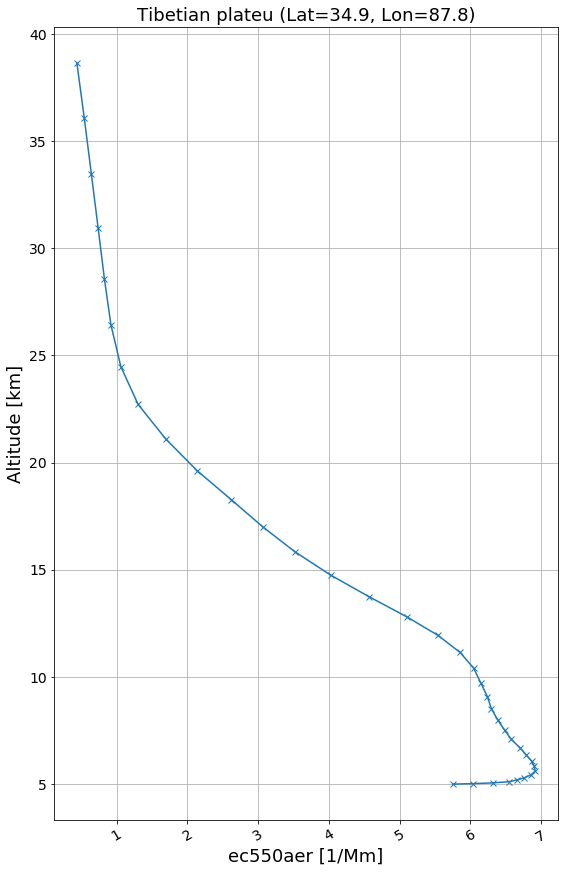

In [26]:
ax = p.plot(figsize=(8, 12))
ax.grid()
ax.set_title('Tibetian plateu (Lat={:.1f}, Lon={:.1f})'.format(LAT, LON));

### Retrieve topography data around this coordinate and compare

In [21]:
topodata = pya.geodesy.get_topo_data(lat0=LAT-1, lon0=LON-2, 
                                     lat1=LAT+1, lon1=LON+2,
                                     topo_dataset='etopo1')

Found default location for etopo1 topodata at
/lustre/storeA/project/aerocom/aerocom1/AEROCOM_OBSDATA/PYAEROCOM/topodata/etopo1/


Invalid input for file_name (None)), setting default: ETOPO1_Ice_g_gmt4.grd


In [22]:
TEST_ALT = topodata.get_altitude(lat=LAT, lon=LON)
TEST_ALT

4986.0

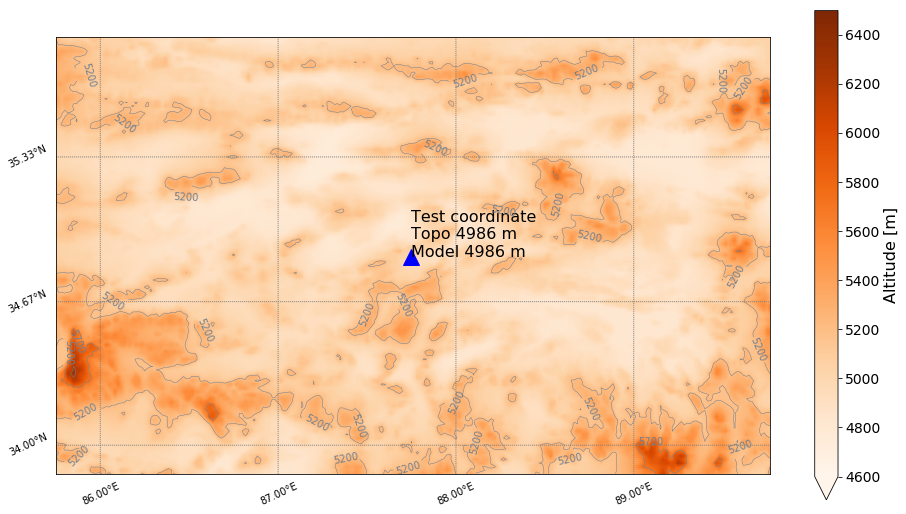

In [23]:
loc = geonum.GeoPoint(LAT, LON, 
                      name='Test coordinate\nTopo {:.0f} m\nModel {:.0f} m'.format(TEST_ALT, MODEL_TOPO_ALT), 
                      auto_topo_access=False)
topo = topodata.plot_2d()
topo.draw_geo_point_2d(loc, c='b', ms=16)
topo.write_point_name_2d(loc, fontsize=16)
topo.ax